In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
import h5py
from tqdm import tqdm
from scipy import signal
from matplotlib import colors
import matplotlib.dates as mdates
ZCAL = 6.66 # (recomputed by comparing power vs Ze)
plt.rcParams['font.size']=15
date_fmt = mdates.DateFormatter('%H:%M')
from tools import get_noise_vectorized

In [2]:
# In this notebook we use data from averaged vertical PPIs

with h5py.File('MXPol_PPI_av_20210127_28.h5') as f:
    Rgate_PPI = f['Rgate'][:]
    Zh_PPI = f['Zh'][:]
    SNRh_PPI = f['SNRh'][:]
    RVel_PPI = f['RVel'][:]
    spec = 10*np.log10(f['spec'][:])
    tstart_PPI = f['tstart'][:]
    tend_PPI = f['tend'][:]
    v= f['v'][:]
Zh_PPI[SNRh_PPI<-4]=-50
dtstart_PPI = [datetime.datetime.utcfromtimestamp(tt) for tt in tstart_PPI]


-16.155515295742692 -4.83238111667864


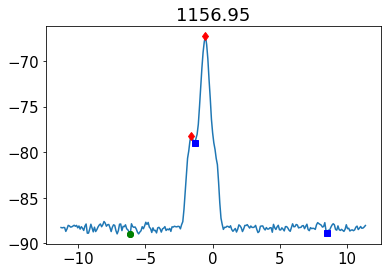

In [6]:
# Select an example of spectrum
irg =38
y = spec[130,irg,:]

# play with the keyword params until a satisfactory result is obtained for several examples of spectra
peaks,properties=signal.find_peaks(y,height=min(y)+4,width=.5,rel_height=.9,distance=4,prominence=.02)

plt.plot(v,y)
plt.plot(v[peaks],y[peaks],'dr')
plt.plot(v[properties['left_bases'].astype('int')], y[properties['left_bases'].astype('int')],'og')
plt.plot(v[properties['right_bases'].astype('int')], y[properties['right_bases'].astype('int')],'sb')
_=plt.title(Rgate_PPI[irg])

y_lin = 10**(y/10)*Rgate_PPI[irg]**2
y_lin = y_lin-np.min(y_lin)
lb = properties['left_bases']
rb = properties['right_bases']
z1 = np.sum(y_lin[lb[0]:rb[0]])
z2 = np.sum(y_lin[rb[0]:rb[1]])
print(10*np.log10(z1)-ZCAL,10*np.log10(z2)-ZCAL)

(array([111, 133,   0]),
 array([ -1.42227331,   0.53335249, -99.        ]),
 array([ 1.21666210e+02,  2.47092512e-02, -9.90000000e+01]),
 array([ -1.25096667,   1.94655578, -99.        ]),
 array([  0.18653961,   4.01527316, -99.        ]))

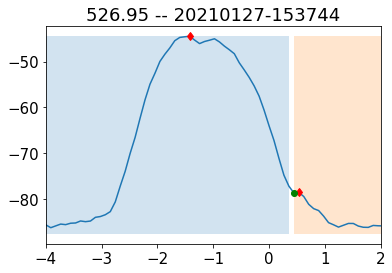

In [4]:
def find_peaks_and_moments(it, irg, plot = False, ref_height = 4, ref_width = .5, ref_rel_height = .5, ref_distance = 6, ref_prominence = .01):
    """
    Finds peaks in Doppler spectrum
    Uses scipy.signal library
    Requires to specify some features so that the code identifies true peaks and not spurious peaks due to noisiness etc.
    To find the appropriate values of these (which depend on the radar, the configuration, etc) some tests should be made, see example in cell above
    """
    z_return = np.array([-99.,-99.,-99.])
    peaks_return = np.array([0,0,0])
    v_peaks_return = np.array([-99.,-99.,-99.])
    meanv_return = np.array([-99.,-99.,-99.])
    sw_return = np.array([-99.,-99.,-99.])
    
    y = spec[it,irg,:]
    
    peaks,properties=signal.find_peaks(y,height=min(y)+ref_height,width=ref_width,rel_height=ref_rel_height,distance=ref_distance,prominence=ref_prominence)
    if len(peaks)>3:
        prom_min = np.sort(properties['prominences'])[-3]
        inds_to_keep = properties['prominences']>=prom_min
        peaks = peaks[inds_to_keep]
        for key in properties.keys():
            properties[key] = properties[key][inds_to_keep]
            
    
    lb = properties['left_bases']
    rb = properties['right_bases']
       
    if len(peaks)==0:
        return(peaks_return,v_peaks_return,z_return,meanv_return, sw_return)
    
        
    peaks_return[:len(peaks)]=peaks
    v_peaks_return[:len(peaks)]=v[peaks]
    
    
    left_edges = np.empty(len(peaks))
    right_edges = np.empty(len(peaks))
    z = np.zeros(3)-999
    left_edges[0] = lb[0]
    right_edges[0] = rb[0]

    if len(peaks) > 1:    
        if lb[1]==lb[0]:
            right_edges[0] = rb[0]
        else:
            right_edges[0] = min(rb[0],lb[1])

        left_edges[1] = right_edges[0]
        right_edges[1] = rb[1]

    if len(peaks)>2:
        if lb[2]<= left_edges[1]: #(lb[2]==lb[0]) | (lb[2]==lb[1]):
            right_edges[1] = rb[1]
        else:
            right_edges[1] = min(rb[1],lb[2])
        left_edges[2] = right_edges[1]
        right_edges[2] = rb[2]
           
    if plot:
        plt.plot(v,y)
        plt.plot(v[peaks],y[peaks],'dr')
        plt.plot(v[properties['left_bases'].astype('int')], y[properties['left_bases'].astype('int')],'og')
        plt.plot(v[properties['right_bases'].astype('int')], y[properties['right_bases'].astype('int')],'sb')
        _=plt.title(str(Rgate_PPI[irg])+datetime.datetime.strftime(dtstart_PPI[it],' -- %Y%m%d-%H%M%S'))
        plt.xlim(-4,2)

        for i in range(len(peaks)):
            plt.fill_between(v[int(left_edges[i]):int(right_edges[i])],y.min(),y.max(),alpha=.2)
    
    y_lin = 10**(y/10)*Rgate_PPI[irg]**2
    y_lin = y_lin-np.min(y_lin)
    y_lin[y_lin<0]=0
    for i in range(len(peaks)):
        z_return[i] = np.sum(y_lin[int(left_edges[i]):int(right_edges[i])])
        meanv_return[i] = np.sum((y_lin*v)[int(left_edges[i]):int(right_edges[i])])/np.sum(y_lin[int(left_edges[i]):int(right_edges[i])])
        sw_return[i] = np.sum((y_lin*(v-meanv_return[i])**2)[int(left_edges[i]):int(right_edges[i])])/np.sum(y_lin[int(left_edges[i]):int(right_edges[i])])

    return(peaks_return,v_peaks_return,z_return,meanv_return, sw_return)
    
# Test the function on an example    
_ = find_peaks_and_moments(80,17,plot=True)

In [2]:
# For a given time index, plot the spectrogram with annotated peaks
# and the profiles of reflectivity corresponding to each mode

it = 50

peaks_stack = np.zeros((len(Rgate_PPI),3))-99.
ze_stack = np.zeros((len(Rgate_PPI),3))-99.
v_peaks_stack = np.zeros((len(Rgate_PPI),3))-99.
sw_peaks_stack = np.zeros((len(Rgate_PPI),3))-99.
meanv_peaks_stack = np.zeros((len(Rgate_PPI),3))-99.


for irg in range(len(Rgate_PPI)):
    peaks_stack[irg,:], v_peaks_stack[irg,:], ze_stack[irg,:], meanv_peaks_stack[irg,:], sw_peaks_stack[irg,:] = find_peaks_and_moments(it,irg)
Ze_stack = 10*np.log10(ze_stack)-ZCAL
spec_wout_noise = 10**(spec[it,:,:]/10)
lnoise,stdv = get_noise_vectorized(spec_wout_noise,4)
spec_wout_noise-=(lnoise+2*stdv)[:,None]
spec_wout_noise[spec_wout_noise<0] = np.nan
fig,axs=plt.subplots(1,2,figsize=(10,8),sharey=True)
im=axs[0].pcolormesh(v,Rgate_PPI,10*np.log10(spec_wout_noise),vmax=-30,cmap='turbo',vmin=-90)
plt.colorbar(im,ax=axs[0],aspect=50,label='spectral power [dB]')
axs[0].scatter(v_peaks_stack[:,0],Rgate_PPI,5,'k')
axs[0].scatter(v_peaks_stack[:,1],Rgate_PPI,5,c='red')#deepskyblue')
axs[0].scatter(v_peaks_stack[:,2],Rgate_PPI,5,'royalblue')
axs[0].grid()
axs[0].set_xlim(-4.5,2)
axs[0].set_ylim(100,4000)
axs[0].set_xlabel('Velocity [m s$^{-1}$]')
axs[0].set_ylabel('Range [m]')

axs[1].scatter(Ze_stack[:,0],Rgate_PPI,10,'k')
axs[1].scatter(Ze_stack[:,1],Rgate_PPI,10,'r')
axs[1].scatter(Ze_stack[:,2],Rgate_PPI,10,'royalblue')
axs[1].set_xlim(-30,30)
axs[1].grid()
axs[1].set_xlabel('Ze of mode [dBZ]')

fig.suptitle(dtstart_PPI[it],y=.93)
#fig.savefig('multi/multimodality_analysis_'+datetime.datetime.strftime(dtstart_PPI[it],'%Y%m%d_%H%M%S'),dpi=300,bbox_inches='tight',facecolor='w')
#plt.close()

NameError: name 'np' is not defined

In [5]:
# Loop through all time steps and range gates to find peaks and corresponding moments

peaks_timeseries = np.zeros((len(tstart_PPI), len(Rgate_PPI),3))-99.
ze_timeseries = np.zeros((len(tstart_PPI), len(Rgate_PPI),3))-99.
v_peaks_timeseries = np.zeros((len(tstart_PPI), len(Rgate_PPI),3))-99.
sw_peaks_timeseries = np.zeros((len(tstart_PPI), len(Rgate_PPI),3))-99.
meanv_peaks_timeseries = np.zeros((len(tstart_PPI),len(Rgate_PPI),3))-99.

for it in tqdm(range(len(tstart_PPI))):
    for irg in range(len(Rgate_PPI)):
        peaks_timeseries[it, irg,:], v_peaks_timeseries[it,irg,:], ze_timeseries[it,irg,:], meanv_peaks_timeseries[it,irg,:], sw_peaks_timeseries[it,irg,:] = find_peaks_and_moments(it,irg)
Ze_timeseries = 10*np.log10(ze_timeseries)-ZCAL


npeaks = np.sum(peaks_timeseries>0,axis=-1)

100%|██████████| 484/484 [00:23<00:00, 20.93it/s]
/home/billault/anaconda3/envs/acbr/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.


In [1]:
# Plot the summary figure 
fig = plt.figure(figsize=(18,4))
cmap = colors.ListedColormap(['white','royalblue','springgreen','gold'])
im=plt.pcolormesh(dtstart_PPI, Rgate_PPI, npeaks.T,cmap=cmap,norm=colors.BoundaryNorm(np.arange(-0.5,4),cmap.N))
cbar=plt.colorbar(im,ticks=[0,1,2,3],label='# peaks',pad=.02)
plt.xlim(datetime.datetime(2021,1,27,11),datetime.datetime(2021,1,28,12))
plt.gca().xaxis.set_major_formatter(date_fmt)
plt.ylim(0,6000)
plt.grid()
# np.save('npeaks',npeaks)
plt.ylabel('Range [m]')
fig.savefig('multimodal_mxpol',dpi=300,bbox_inches='tight',facecolor='w')

NameError: name 'colors' is not defined

In [194]:
# Calculate the proportion of total reflectivity contained in each mode (assuming 3 modes)

ze_proportions_timeseries = np.zeros(ze_timeseries.shape)
ze_timeseries[:,:,0][ze_timeseries[:,:,0]<0]=np.nan
ze_timeseries[:,:,1][ze_timeseries[:,:,1]<0]=np.nan
ze_timeseries[:,:,2][ze_timeseries[:,:,2]<0]=np.nan

ze_proportions_timeseries[:,:,0] = ze_timeseries[:,:,0]/np.nansum(ze_timeseries,axis=-1)
ze_proportions_timeseries[:,:,1] = ze_timeseries[:,:,1]/np.nansum(ze_timeseries,axis=-1)
ze_proportions_timeseries[:,:,2] = ze_timeseries[:,:,2]/np.nansum(ze_timeseries,axis=-1)
# ze_timeseries.shape


/home/billault/anaconda3/envs/acbr/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


(0.0, 4500.0)

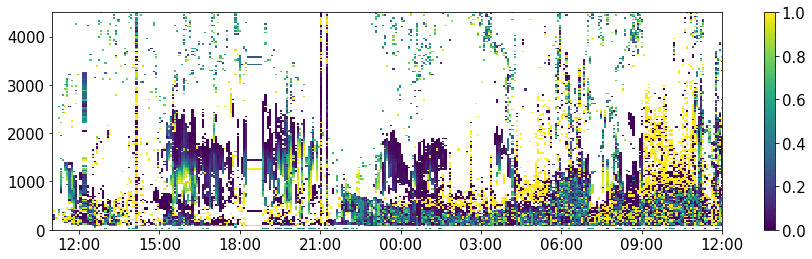

In [208]:
fig = plt.figure(figsize=(15,4))
plt.pcolormesh(dtstart_PPI,Rgate_PPI,ze_proportions_timeseries[:,:,1].T,vmin=0,vmax=1)
plt.colorbar()
plt.xlim(datetime.datetime(2021,1,27,11),datetime.datetime(2021,1,28,12))
plt.gca().xaxis.set_major_formatter(date_fmt)
plt.ylim(0,4500)